In [1]:
%%html
<style>
    #notebook-container{
    width: 100%
    }
</style>

In [2]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stat

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import model_selection
from scipy import stats
from sklearn.svm import SVR

sns.set()

In [3]:
# telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Statistic/master/telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2. The variable "tenure" is taken as the dependent variable and the remaining variables as explanatory. <br>

## Subtask 1.

The lasso regression is an alternative approach to variable selection. <br>

### Part (a)
Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

### Part (b)

For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \bar x)/\hat \sigma_x$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable "ed"?

For Lasso regression scaling of data become crucial because independent variables should be centered around 0 (have mean of 0). Because of this reason we perform scaling of data as per formula $\frac{(x_i - \bar x)}{\hat \sigma_x}$. Without scaling Lasso regression would provide a wrong results - countours of Least Square solution will intersect with non-scaled data in different points than it should. <br>

As for binary variables - those should be scaled as well. Otherwise for such variables like "gender" mean value will be around 0.5 and not 0 as it should be. Same holds for other binary variables - mean value is not equal to 0 as result Lasso regression will produce wrong results. Hence, I am also scaling all dummy variables to center those around mean of 0. <br>

For variable "ed", in addition to scaling, we also need to group all education related dummy variables and perform group Lasso regression which keeps related dummy variables as single group. In such case either none or all of such variables are excluded. Grouped dummy variables could not be excluded partially.

In [4]:
telco_df_norm = telco_df.copy() #normalizing data

telco_df_norm.tenure = (telco_df_norm.tenure-telco_df_norm.tenure.mean()) / telco_df_norm.tenure.std()
telco_df_norm.age = (telco_df_norm.age-telco_df_norm.age.mean()) / telco_df_norm.age.std()
telco_df_norm.address = (telco_df_norm.address-telco_df_norm.address.mean()) / telco_df_norm.address.std()
telco_df_norm.income = (telco_df_norm.income-telco_df_norm.income.mean()) / telco_df_norm.income.std()
telco_df_norm.employ = (telco_df_norm.employ-telco_df_norm.employ.mean()) / telco_df_norm.employ.std()
telco_df_norm.longmon = (telco_df_norm.longmon-telco_df_norm.longmon.mean()) / telco_df_norm.longmon.std()
telco_df_norm.wiremon = (telco_df_norm.wiremon-telco_df_norm.wiremon.mean()) / telco_df_norm.wiremon.std()

telco_df_norm.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00


In [5]:
telco_df_norm_dummy = telco_df_norm.copy()

telco_df_norm_dummy = pd.get_dummies(telco_df_norm, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))

telco_df_norm_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_norm_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_norm_dummy.marital_dummy = (telco_df_norm_dummy.marital_dummy-telco_df_norm_dummy.marital_dummy.mean()) / telco_df_norm_dummy.marital_dummy.std()
telco_df_norm_dummy.retire_dummy = (telco_df_norm_dummy.retire_dummy-telco_df_norm_dummy.retire_dummy.mean()) / telco_df_norm_dummy.retire_dummy.std()
telco_df_norm_dummy.gender_dummy = (telco_df_norm_dummy.gender_dummy-telco_df_norm_dummy.gender_dummy.mean()) / telco_df_norm_dummy.gender_dummy.std()
telco_df_norm_dummy.churn_dummy = (telco_df_norm_dummy.churn_dummy-telco_df_norm_dummy.churn_dummy.mean()) / telco_df_norm_dummy.churn_dummy.std()
telco_df_norm_dummy.ed_dummy_college_degree = (telco_df_norm_dummy.ed_dummy_college_degree-telco_df_norm_dummy.ed_dummy_college_degree.mean()) / telco_df_norm_dummy.ed_dummy_college_degree.std()
telco_df_norm_dummy.ed_dummy_no_high_school = (telco_df_norm_dummy.ed_dummy_no_high_school-telco_df_norm_dummy.ed_dummy_no_high_school.mean()) / telco_df_norm_dummy.ed_dummy_no_high_school.std()
telco_df_norm_dummy.ed_dummy_high_school = (telco_df_norm_dummy.ed_dummy_high_school-telco_df_norm_dummy.ed_dummy_high_school.mean()) / telco_df_norm_dummy.ed_dummy_high_school.std()
telco_df_norm_dummy.ed_dummy_some_college = (telco_df_norm_dummy.ed_dummy_some_college-telco_df_norm_dummy.ed_dummy_some_college.mean()) / telco_df_norm_dummy.ed_dummy_some_college.std()

telco_df_norm_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16,9.992007e-17,-1.318390e-16,-2.435829e-16,6.616929e-17,-8.992806e-17,-1.403322e-16,1.296740e-16,1.183498e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01,1.009545e+00,-2.219654e-01,1.034081e+00,1.626956e+00,-5.524288e-01,-5.059893e-01,1.575384e+00,-5.137687e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00,1.009545e+00,4.500702e+00,1.034081e+00,1.626956e+00,1.808378e+00,1.974350e+00,1.575384e+00,1.944455e+00


### Part (c)

Run a lasso regression for data with $\lambda \in (0, 1)$. Plot the estimated parameters as functions of $\lambda$. Which value of $\lambda$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

For alpha=0.80000
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79900
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79800
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79700
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79600
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79500
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79400
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79300
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79200
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79100
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79000
Training score: 0.00000
Test score: -0.02047
Number of feature

For alpha=0.70100
Training score: 0.04953
Test score: 0.02398
Number of features used: 1 

For alpha=0.70000
Training score: 0.05081
Test score: 0.02514
Number of features used: 1 

For alpha=0.69900
Training score: 0.05209
Test score: 0.02629
Number of features used: 1 

For alpha=0.69800
Training score: 0.05337
Test score: 0.02745
Number of features used: 1 

For alpha=0.69700
Training score: 0.05465
Test score: 0.02860
Number of features used: 1 

For alpha=0.69600
Training score: 0.05592
Test score: 0.02976
Number of features used: 1 

For alpha=0.69500
Training score: 0.05719
Test score: 0.03091
Number of features used: 1 

For alpha=0.69400
Training score: 0.05847
Test score: 0.03206
Number of features used: 1 

For alpha=0.69300
Training score: 0.05974
Test score: 0.03321
Number of features used: 1 

For alpha=0.69200
Training score: 0.06100
Test score: 0.03435
Number of features used: 1 

For alpha=0.69100
Training score: 0.06227
Test score: 0.03550
Number of features used: 1 


For alpha=0.58900
Training score: 0.18177
Test score: 0.14562
Number of features used: 1 

For alpha=0.58800
Training score: 0.18284
Test score: 0.14664
Number of features used: 1 

For alpha=0.58700
Training score: 0.18392
Test score: 0.14765
Number of features used: 1 

For alpha=0.58600
Training score: 0.18499
Test score: 0.14866
Number of features used: 1 

For alpha=0.58500
Training score: 0.18606
Test score: 0.14967
Number of features used: 1 

For alpha=0.58400
Training score: 0.18713
Test score: 0.15068
Number of features used: 1 

For alpha=0.58300
Training score: 0.18820
Test score: 0.15168
Number of features used: 1 

For alpha=0.58200
Training score: 0.18927
Test score: 0.15269
Number of features used: 1 

For alpha=0.58100
Training score: 0.19033
Test score: 0.15369
Number of features used: 1 

For alpha=0.58000
Training score: 0.19140
Test score: 0.15470
Number of features used: 1 

For alpha=0.57900
Training score: 0.19246
Test score: 0.15570
Number of features used: 1 


Training score: 0.29104
Test score: 0.25109
Number of features used: 1 

For alpha=0.47600
Training score: 0.29191
Test score: 0.25195
Number of features used: 1 

For alpha=0.47500
Training score: 0.29279
Test score: 0.25282
Number of features used: 1 

For alpha=0.47400
Training score: 0.29365
Test score: 0.25369
Number of features used: 1 

For alpha=0.47300
Training score: 0.29452
Test score: 0.25455
Number of features used: 1 

For alpha=0.47200
Training score: 0.29539
Test score: 0.25542
Number of features used: 1 

For alpha=0.47100
Training score: 0.29625
Test score: 0.25628
Number of features used: 1 

For alpha=0.47000
Training score: 0.29711
Test score: 0.25714
Number of features used: 1 

For alpha=0.46900
Training score: 0.29797
Test score: 0.25800
Number of features used: 1 

For alpha=0.46800
Training score: 0.29883
Test score: 0.25886
Number of features used: 1 

For alpha=0.46700
Training score: 0.29968
Test score: 0.25972
Number of features used: 1 

For alpha=0.46600

Training score: 0.37869
Test score: 0.34181
Number of features used: 1 

For alpha=0.36200
Training score: 0.37935
Test score: 0.34253
Number of features used: 1 

For alpha=0.36100
Training score: 0.38018
Test score: 0.34340
Number of features used: 2 

For alpha=0.36000
Training score: 0.38110
Test score: 0.34435
Number of features used: 2 

For alpha=0.35900
Training score: 0.38201
Test score: 0.34530
Number of features used: 2 

For alpha=0.35800
Training score: 0.38292
Test score: 0.34624
Number of features used: 2 

For alpha=0.35700
Training score: 0.38383
Test score: 0.34718
Number of features used: 2 

For alpha=0.35600
Training score: 0.38474
Test score: 0.34812
Number of features used: 2 

For alpha=0.35500
Training score: 0.38564
Test score: 0.34905
Number of features used: 2 

For alpha=0.35400
Training score: 0.38654
Test score: 0.34999
Number of features used: 2 

For alpha=0.35300
Training score: 0.38744
Test score: 0.35092
Number of features used: 2 

For alpha=0.35200

Training score: 0.47623
Test score: 0.44551
Number of features used: 4 

For alpha=0.25400
Training score: 0.47700
Test score: 0.44635
Number of features used: 4 

For alpha=0.25300
Training score: 0.47775
Test score: 0.44720
Number of features used: 4 

For alpha=0.25200
Training score: 0.47851
Test score: 0.44804
Number of features used: 4 

For alpha=0.25100
Training score: 0.47926
Test score: 0.44888
Number of features used: 4 

For alpha=0.25000
Training score: 0.48001
Test score: 0.44972
Number of features used: 4 

For alpha=0.24900
Training score: 0.48075
Test score: 0.45055
Number of features used: 4 

For alpha=0.24800
Training score: 0.48150
Test score: 0.45138
Number of features used: 4 

For alpha=0.24700
Training score: 0.48224
Test score: 0.45221
Number of features used: 4 

For alpha=0.24600
Training score: 0.48297
Test score: 0.45304
Number of features used: 4 

For alpha=0.24500
Training score: 0.48371
Test score: 0.45387
Number of features used: 4 

For alpha=0.24400

For alpha=0.14500
Training score: 0.54653
Test score: 0.53333
Number of features used: 5 

For alpha=0.14400
Training score: 0.54708
Test score: 0.53417
Number of features used: 5 

For alpha=0.14300
Training score: 0.54764
Test score: 0.53502
Number of features used: 5 

For alpha=0.14200
Training score: 0.54819
Test score: 0.53586
Number of features used: 5 

For alpha=0.14100
Training score: 0.54874
Test score: 0.53669
Number of features used: 5 

For alpha=0.14000
Training score: 0.54928
Test score: 0.53752
Number of features used: 5 

For alpha=0.13900
Training score: 0.54982
Test score: 0.53835
Number of features used: 5 

For alpha=0.13800
Training score: 0.55036
Test score: 0.53918
Number of features used: 5 

For alpha=0.13700
Training score: 0.55089
Test score: 0.54000
Number of features used: 5 

For alpha=0.13600
Training score: 0.55142
Test score: 0.54081
Number of features used: 5 

For alpha=0.13500
Training score: 0.55194
Test score: 0.54163
Number of features used: 5 


For alpha=0.04100
Training score: 0.60667
Test score: 0.60576
Number of features used: 8 

For alpha=0.04000
Training score: 0.60716
Test score: 0.60620
Number of features used: 8 

For alpha=0.03900
Training score: 0.60764
Test score: 0.60663
Number of features used: 8 

For alpha=0.03800
Training score: 0.60811
Test score: 0.60704
Number of features used: 8 

For alpha=0.03700
Training score: 0.60856
Test score: 0.60745
Number of features used: 8 

For alpha=0.03600
Training score: 0.60900
Test score: 0.60784
Number of features used: 8 

For alpha=0.03500
Training score: 0.60943
Test score: 0.60822
Number of features used: 8 

For alpha=0.03400
Training score: 0.60985
Test score: 0.60858
Number of features used: 8 

For alpha=0.03300
Training score: 0.61026
Test score: 0.60894
Number of features used: 8 

For alpha=0.03200
Training score: 0.61065
Test score: 0.60928
Number of features used: 8 

For alpha=0.03100
Training score: 0.61103
Test score: 0.60962
Number of features used: 8 


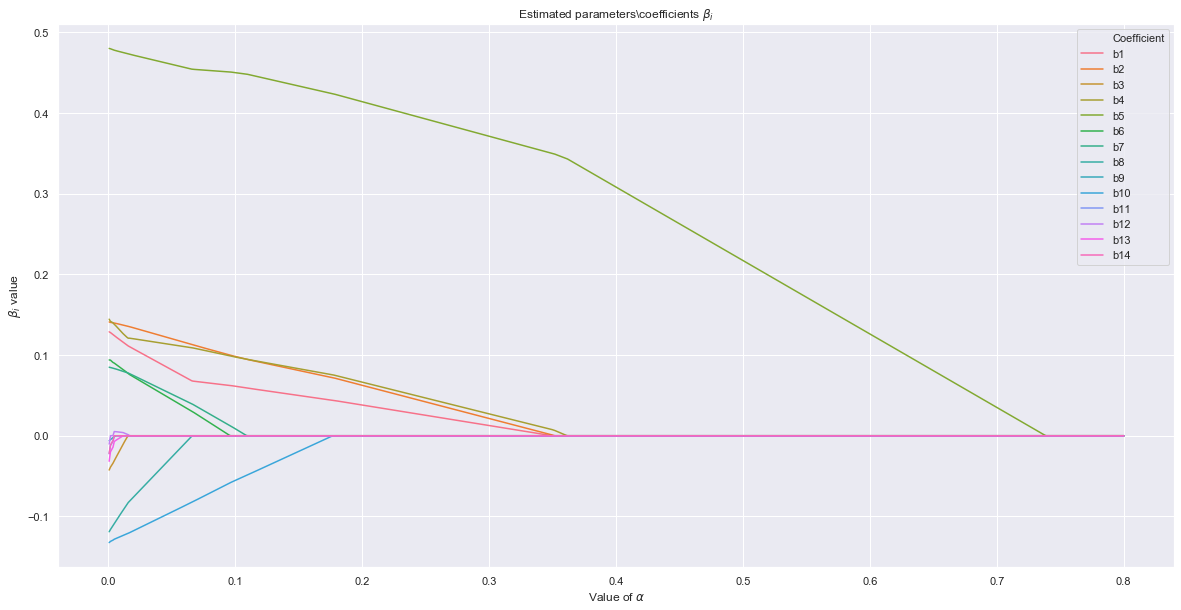

In [6]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

# lambdas = [0.9, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001]
lambdas = np.arange(0.8, 0, -0.001)
coefficients = []

for lambd in lambdas:
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y, test_size=0.3, random_state=7)

    lasso = linear_model.Lasso(alpha=lambd)
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    coefficients.append(lasso.coef_)

    print("For alpha=%.5f" %lambd)
    print("Training score: %.5f" %train_score )
    print("Test score: %.5f" %test_score)
    print("Number of features used: %s \n" %coeff_used)
    

coefficients_df = pd.DataFrame(coefficients, columns=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14"])
coefficients_df['alpha'] = lambdas
coefficients_df = coefficients_df.melt(id_vars=['alpha'], var_name='Coefficient')
coefficients_df.tail()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="alpha", y="value", hue="Coefficient", data=coefficients_df, )
# sns.lineplot(x=alphas, y="b2", data=coefficients_df)
# sns.lineplot(x=alphas, y="b3", data=coefficients_df)
plt.title("Estimated parameters\coefficients $\\beta_i$")
plt.ylabel("$\\beta_i$ value")
plt.xlabel("Value of $\\alpha$")
plt.show()

From this plot and printed test errors we could see that more or less accuracy of 61% achieved around $\lambda = 0.03$ so it make sense to recommend this value. Also with this values of $\lambda$ there is only 8 non-zero features coefficients and others are zeroed out. Now I would try to find optimal values of $\lambda$ by cross-validation.

In [7]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

lassoCV = linear_model.LassoCV(cv=15, random_state=7)
lassoCV.fit(X, Y)

print("Final score of CV: %.5f" %lassoCV.score(X, Y))
print("Optimal value of found by CV lambda = %.5f" %lassoCV.alpha_)
print("Optimal coefficients found by CV: %s" %lassoCV.coef_.round(5))

Final score of CV: 0.62021
Optimal value of found by CV lambda = 0.01162
Optimal coefficients found by CV: [ 0.09673  0.1427  -0.       0.11734  0.51164  0.05954  0.06464 -0.08162
 -0.0027  -0.1452  -0.00884  0.      -0.      -0.     ]


Optimal value of $\lambda$ found by Cross Validation is $\lambda=0.01162$.

## Subtask 2.

A nonlinear regression oﬀers a ﬂexible technique for modelling complex relationships. We wish to explain the "tenure" by the long distance calls per month "longmon". <br>

### Part (a)

Make a bivariate scatter plot and estimate an appropriate linear model. Add the regression line to the plot. 

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


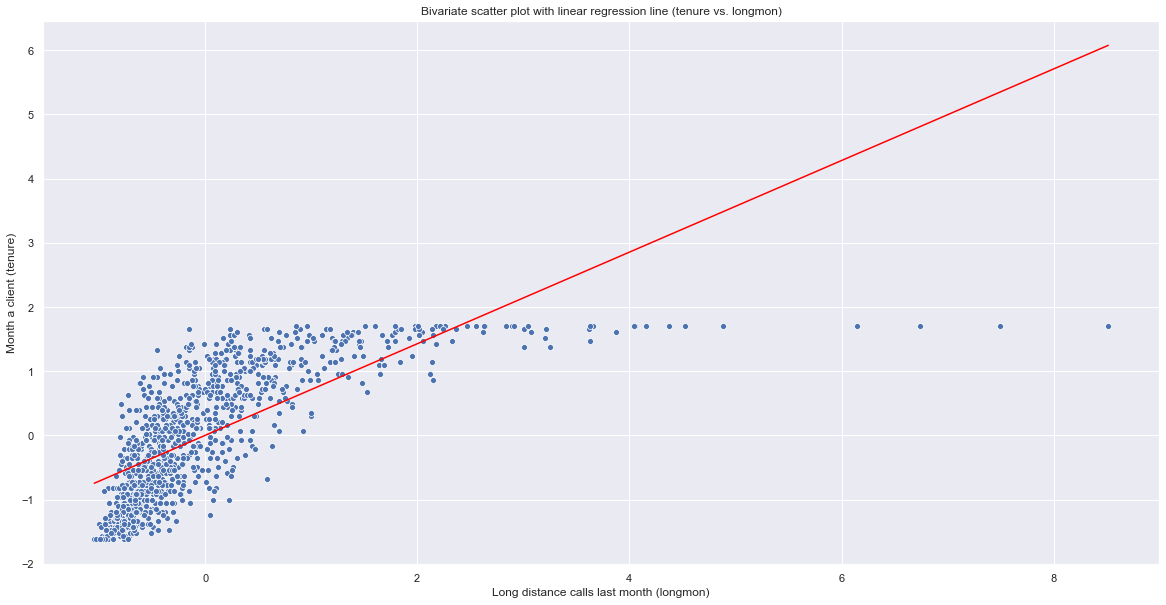

Adjusted R2 score of linear model: 0.50884
Root Mean Square Error (RMSE) of linear model: 0.70012


In [8]:
X = telco_df_norm_dummy.copy().longmon
X = sm.add_constant(X)
Y = telco_df_norm_dummy.copy().tenure

result = sm.OLS(Y , X).fit()

Y_pred_man = np.dot(X, result.params)

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=Y_pred_man, color='red')
plt.title("Bivariate scatter plot with linear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - result.fittedvalues)**2).mean())
print("Adjusted R2 score of linear model: %.5f" %result.rsquared_adj)
print("Root Mean Square Error (RMSE) of linear model: %.5f" %rmse)

# result.summary()

### Part(b)

Estimate now an appropriate nonlinear regression which might ﬁt the data better. Add the regression curve to the plot and compare (quantitatively) the ﬁt with the ﬁt of the linear model. 

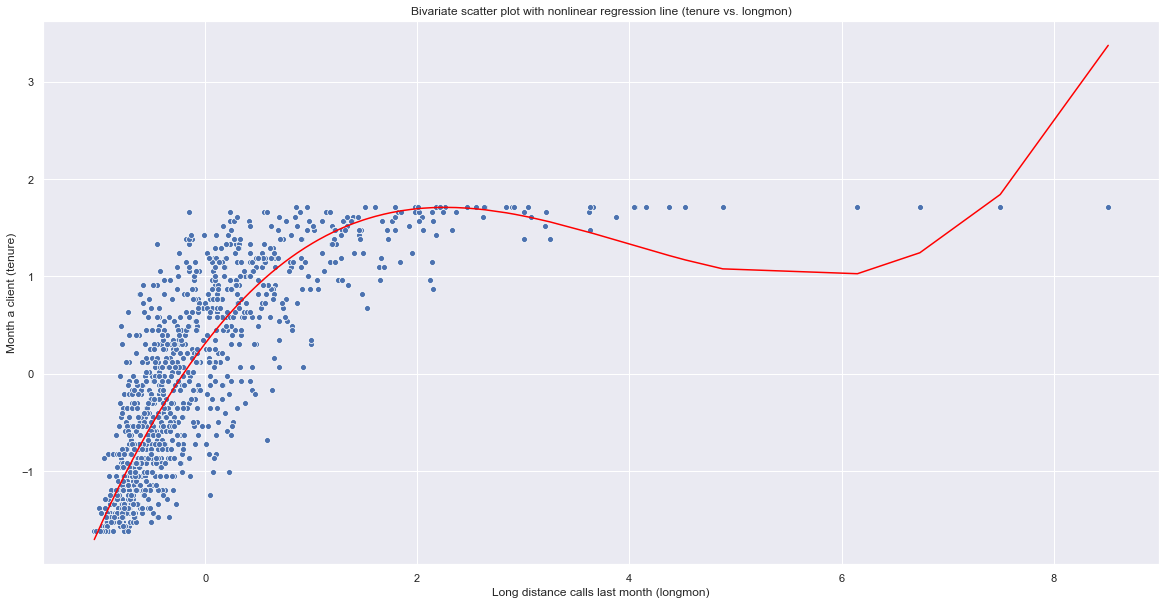

R2 score of nonlinear model: 0.71297
Root Mean Square Error (RMSE) of nonlinear model: 0.53548


In [9]:
X = telco_df_norm_dummy.copy().longmon
X = X.to_numpy().reshape(-1, 1)
Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
model.fit(X,Y)

plt.figure(figsize=(20,10))
sns.scatterplot(x=X.reshape(-1), y=telco_df_norm_dummy.tenure)
sns.lineplot(x=X.reshape(-1), y=model.predict(X), color='red')
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean())
print("R2 score of nonlinear model: %.5f" %model.score(X,Y))
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

To compare linear regression fit with nonlinear one numerically we could use Root Mean Square Error (RMSE) value of both models. I have calcualted it for each model by subtracting predicted value from real one, then square difference, calculate mean of all squared deviations and take square root from mean in the end. Since RMSE of linear model is 0.70012 and RMSE of nonlinear model is 0.53548 we could conclude that non-linear model fits given data better.

### Part (c)

Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.

Classical test and inferences assume normal distribution of observations (or errors). However, in case of NLS estimators distribution of model errors is not normal one. Hence those tests and inferences are not directly applicable to NLS estimators. Resulting $\hat \beta$ is not a linear function of residuals $u_k$, because of this $\hat \beta$ has non-linear distribution. But still Maximum Likelihood (ML) estimators are consistent and efficient for NLS because they have smallest variance among all estimators (best of what we can get). All tests and inferences valid only asymptotically.

### Part (d)

What kind of problems might arise if we decide to ﬁt a non-linear regression using all explanatory variables?

In case if we will decide to fit nonlinear regression using all explanatory variables we will end up with very complex nonlinear function. Below I have visualize same plot as above, but model was fitted to all variables and not only to "longmon". As you could see - function is extremly complex in such case. It is impossible to find manually such complex function. Another issue - function is definetly overfitted with regards to training data. Most probably such model will behave badly on unseen (test) data. Also, such higly nonlinear systems could be solved only numerically - no exact solution exist.

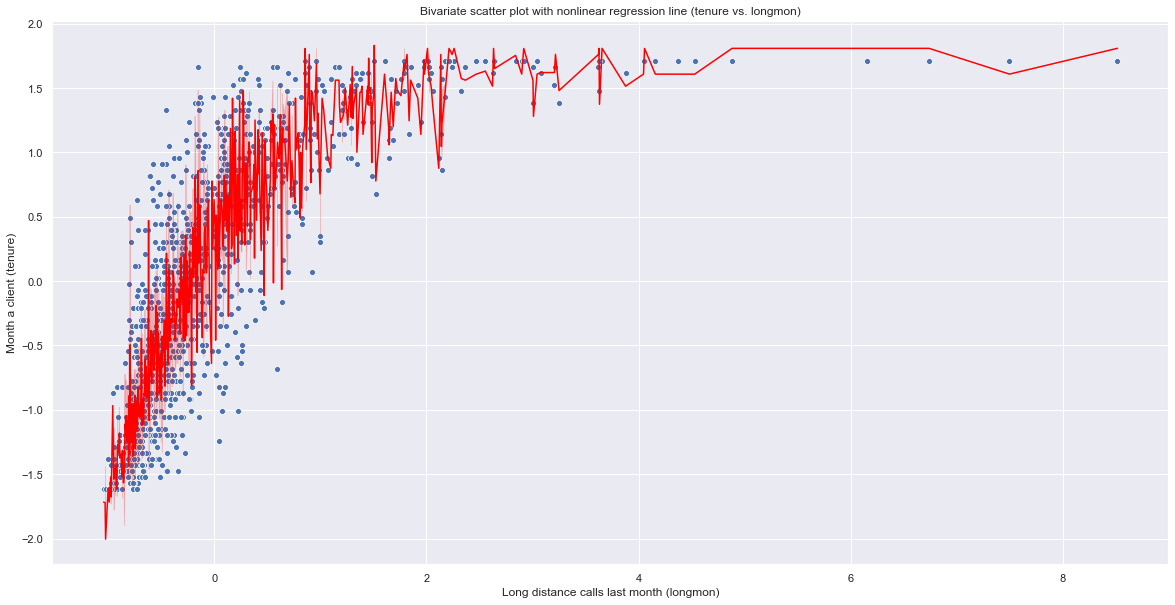

R2 score of nonlinear model: 0.84106
Root Mean Square Error (RMSE) of nonlinear model: 0.39847


In [10]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])

Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
model.fit(X,Y)

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=model.predict(X), color='red')
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean())
print("R2 score of nonlinear model: %.5f" %model.score(X,Y))
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

## Subtask 3.

Next we model the relationship between "tenure" and "longmon" using the nonparametric Nadaraya-Watson regression.

### Part (a)

An important calibration parameter of a nonparametric regression is the bandwidth. Explain what happens with the regression/the weights in the Nadaraya-Watson regression if the bandwidth is too high or too small.

All Kernel Density Estimators heavily depends on bandwith $h$ and Nadaraya-Watson regression is not an exclusion here. Kernels are window functions width of which are set by bandwith parameter. So with $h \rightarrow \inf$ kernel will include all points with equal weights and regression will look like linear regression. On opposite, if $h$ is small - then model will fit values locally, means it will fit mean to each point individually. So bandwith $h$ determines how local kernel density estimator with regards to points $X_i$.

### Part (b)

Fit a Nadaraya-Watson regression with Gaussian kernel and “optimal” bandwidth to the "longmon"/"tenure" data. Check and explain how the “optimal bandwidth” is determined in your software. Compare the (in-sample) ﬁt of the nonparametric regression and the nonlinear regression in the previous subproblem.

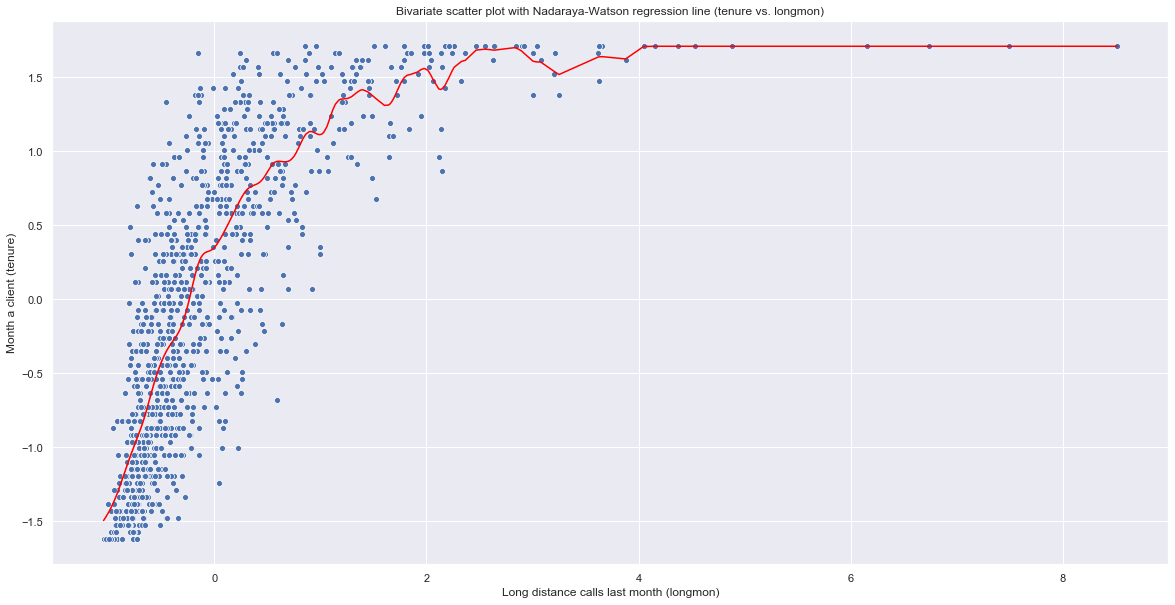

R2 score of Nadaraya-Watson model: 0.72775
Root Mean Square Error (RMSE) of nonlinear model: 0.52171


In [14]:
from statsmodels.nonparametric.kernel_regression import KernelReg

X = telco_df_norm_dummy.copy().longmon
Y = telco_df_norm_dummy.copy().tenure

NWmodel = KernelReg(endog=Y, exog=X, var_type='c', ckertype='gaussian', reg_type='lc', bw='cv_ls')

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=NWmodel.fit(X)[0], color='red')
plt.title("Bivariate scatter plot with Nadaraya-Watson regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - NWmodel.fit(X)[0])**2).mean())
print("R2 score of Nadaraya-Watson model: %.5f" %NWmodel.r_squared())
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)



Comparing $R^2$ score and RMSE of Nadaraya-Watson (NW) model with nonlinear model we could see that NW model is sligntly better - it has higher $R^2$ score and lower RMSE. But difference itself is minor one. Hence, I could conclude that in this particular case nonlinear regression and nonparametric NW regression leads to simillar results.